<a href="https://colab.research.google.com/github/mebirtukan/EyeMovementEventDetectionAlgorithms/blob/main/CNN_CLASSIFIER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPool1D, Conv2D, BatchNormalization
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, cohen_kappa_score



In [ ]:
!wget www.kasprowski.pl/datasets/events.zip
!unzip events.zip > xx


--2022-08-25 23:12:41--  http://www.kasprowski.pl/datasets/events.zip
Resolving www.kasprowski.pl (www.kasprowski.pl)... 94.152.164.213
Connecting to www.kasprowski.pl (www.kasprowski.pl)|94.152.164.213|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2909538 (2.8M) [application/zip]
Saving to: ‘events.zip’

events.zip          100%[===================>]   2.77M  2.35MB/s    in 1.2s    

2022-08-25 23:12:43 (2.35 MB/s) - ‘events.zip’ saved [2909538/2909538]



In [ ]:
def openfile(filename):
  mat = loadmat(filename)
  mdata = mat['ETdata']
  mtype = mdata.dtype
  ndata = {n: mdata[n][0,0] for n in mtype.names}
  data_headline = ndata['pos']
  data_headline = data_headline[0]
  data_raw = ndata['pos']
  pdata = pd.DataFrame(data_raw,columns=data_headline)
  df=pd.DataFrame(pdata)
  df[1.0]=df[1.0].astype(int)
  #t=pdata.iloc[:, 0].values maybe we should use it...
  x=pdata.iloc[:, 3:5].values
  y=pdata.iloc[:, 5].values
  print("File",filename,"opened")
  return x ,y

In [ ]:
# data has two coordinates: X,Y returns velX and velY
def calc_xy_velocity(data):
  velX = [] #x values difference
  velY = [] #y values difference 

  for i in range(len(data) - 1):
    velX.append(float(data[i+1,0]) - float(data[i,0]) ) # 2ms!
    velY.append(float(data[i+1,1]) - float(data[i,1]) )
  velX = np.array(velX)
  velY = np.array(velY)
  velocity = np.vstack([velX,velY]).T
  return velocity

# data has two coordinates: X,Y returns ONE velocity
def calc_velocity(data):
  velX = [] #x values difference
  velY = [] #y values difference 
  for i in range(len(data) - 1):
    velX.append(float(data[i+1,0]) - float(data[i,0]) ) # 2ms!
    velY.append(float(data[i+1,1]) - float(data[i,1]) )
  velX = np.array(velX)
  velY = np.array(velY)
  velocity = np.sqrt(np.power(velX,2) + np.power(velY,2))
  print(velocity.shape)  
  return velocity

In [ ]:
def open_list_of_files(files_to_load):
  samples = []
  labels =[]
  for my_file in files_to_load:
    sam,lab = openfile(my_file)
    #ssam,slab = make_sequences(sam,lab,50)
    print('Number of samples so far:',len(samples))
    samples.extend(sam)
    labels.extend(lab)
  samples = np.array(samples)
  labels = np.array(labels)
  print('Number of samples at the end:',len(samples))
  return samples,labels
files_to_load = ['data/UH33_img_vy_labelled_MN.mat','data/UH47_img_Europe_labelled_MN.mat','data/UH47_img_Europe_labelled_RA.mat','data/UH21_img_Rome_labelled_MN.mat', 'data/UH27_img_vy_labelled_MN.mat']
files_to_load1 = ['data/TH34_img_Europe_labelled_MN.mat', 'data/UH21_img_Rome_labelled_RA.mat']
#files_to_load = ['data/UH21_img_Rome_labelled_MN.mat']
#files_to_load1 = ['data/TH34_img_Europe_labelled_MN.mat']

s,l = open_list_of_files(files_to_load)
s1,l1=open_list_of_files(files_to_load1)
print(s.shape)
print(l.shape)
print(s1.shape)
print(l1.shape)

File data/UH33_img_vy_labelled_MN.mat opened
Number of samples so far: 0
File data/UH47_img_Europe_labelled_MN.mat opened
Number of samples so far: 4988
File data/UH47_img_Europe_labelled_RA.mat opened
Number of samples so far: 6985
File data/UH21_img_Rome_labelled_MN.mat opened
Number of samples so far: 8982
File data/UH27_img_vy_labelled_MN.mat opened
Number of samples so far: 13970
Number of samples at the end: 18958
File data/TH34_img_Europe_labelled_MN.mat opened
Number of samples so far: 0
File data/UH21_img_Rome_labelled_RA.mat opened
Number of samples so far: 4988
Number of samples at the end: 9976
(18958, 2)
(18958,)
(9976, 2)
(9976,)


In [ ]:
# sequence 
def make_sequences(samples, labels, sequence_dim = 100, sequence_lag = 1, sequence_attributes = 2):
    nsamples = []
    nlabels = [] 
    for i in range(0,samples.shape[0]-sequence_dim,sequence_lag):
            nsample = np.zeros((sequence_dim,sequence_attributes))
            for j in range(i,i+sequence_dim):
                nsample[j-i,0] = samples[j,0]
                nsample[j-i,1] = samples[j,1]
            nlabel = labels[i+sequence_dim//2]
            #print("Sample",nsample)
            #print("Label",nlabel)
            nsamples.append(nsample)
            nlabels.append(nlabel)
        
    samples = np.array(nsamples)
    labels = np.array(nlabels)
    return samples,labels 

In [ ]:
s = calc_xy_velocity(s)
s1 = calc_xy_velocity(s1)

sequence_dim = 100
print("Samples shape before sequencing",s.shape)

print("Converting to sequences of length {}".format(sequence_dim))
x, y = make_sequences(s, l, sequence_dim)
x1, y1 = make_sequences(s1, l1, sequence_dim)
print("Samples shape after sequencing: {}".format(x.shape))
print("Labels shape after sequencing: {}".format(y.shape))

Samples shape before sequencing (18957, 2)
Converting to sequences of length 100
Samples shape after sequencing: (18857, 100, 2)
Labels shape after sequencing: (18857,)


In [ ]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit(y)
y = lb.transform(y)
y1 = lb.transform(y1)


In [ ]:
y1.shape

(9874, 3)

In [ ]:
#Build CNN Model

inputShape = (sequence_dim, 2)
#inputShape = (x.shape)
print('inputShape:',inputShape)
model = Sequential()
model.add(Conv1D(32, 3,input_shape=inputShape))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.2))

model.add(Conv1D(64, 3, padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.2))
model.add(Conv1D(128, 3, padding="same"))
model.add(Activation("relu"))
model.add(Dropout(0.2))
model.add(Flatten())
#model.add(Dense(128, activation='sigmoid'))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(3, activation='softmax'))
#model.add(Dense(3, activation='softmax'))

model.summary()

inputShape: (100, 2)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 98, 32)            224       
                                                                 
 batch_normalization_10 (Bat  (None, 98, 32)           128       
 chNormalization)                                                
                                                                 
 activation_14 (Activation)  (None, 98, 32)            0         
                                                                 
 dropout_13 (Dropout)        (None, 98, 32)            0         
                                                                 
 conv1d_16 (Conv1D)          (None, 98, 64)            6208      
                                                                 
 batch_normalization_11 (Bat  (None, 98, 64)           256       
 chNormalization)                

In [ ]:
#from tensorflow.keras.utils import plot_model
#plot_model(model)

In [ ]:
model.save('CNN_CLASS.h5')

In [ ]:
!pip install netron

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import netron

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer="adam",metrics=['accuracy'])
    
EPOCHS=20
BATCH=100
model.fit(x, y, batch_size=BATCH, epochs=EPOCHS
              ,validation_data=(x1,y1)
              )
    

print("Training")
cnnResults = model.predict(x)
print(confusion_matrix(y.argmax(axis=1), cnnResults.argmax(axis=1)))
print(classification_report(y.argmax(axis=1), cnnResults.argmax(axis=1)))
print("CNN Accuracy: {:.2f}".format(accuracy_score(y.argmax(axis=1), cnnResults.argmax(axis=1))))
print("Cohen's Kappa {:.2f}".format(cohen_kappa_score(y.argmax(axis=1), cnnResults.argmax(axis=1))))

print("Test")
cnnResults = model.predict(x1)
print(confusion_matrix(y1.argmax(axis=1), cnnResults.argmax(axis=1)))
print(classification_report(y1.argmax(axis=1), cnnResults.argmax(axis=1)))
CM=(confusion_matrix(y1.argmax(axis=1), cnnResults.argmax(axis=1)))
print("CNN Accuracy: {:.2f}".format(accuracy_score(y1.argmax(axis=1), cnnResults.argmax(axis=1))))
print("Cohen's Kappa {:.2f}".format(cohen_kappa_score(y1.argmax(axis=1), cnnResults.argmax(axis=1))))

Epoch 1/20
189/189 [==============================] - 29s 143ms/step - loss: 0.1797 - accuracy: 0.9337 - val_loss: 0.1200 - val_accuracy: 0.9588
Epoch 2/20
189/189 [==============================] - 24s 129ms/step - loss: 0.1165 - accuracy: 0.9568 - val_loss: 0.1032 - val_accuracy: 0.9601
Epoch 3/20
189/189 [==============================] - 25s 130ms/step - loss: 0.0984 - accuracy: 0.9615 - val_loss: 0.0921 - val_accuracy: 0.9649
Epoch 4/20
189/189 [==============================] - 23s 122ms/step - loss: 0.0837 - accuracy: 0.9675 - val_loss: 0.0840 - val_accuracy: 0.9689
Epoch 5/20
189/189 [==============================] - 24s 125ms/step - loss: 0.0728 - accuracy: 0.9717 - val_loss: 0.0806 - val_accuracy: 0.9678
Epoch 6/20
189/189 [==============================] - 23s 122ms/step - loss: 0.0673 - accuracy: 0.9735 - val_loss: 0.0834 - val_accuracy: 0.9695
Epoch 7/20
189/189 [==============================] - 24s 128ms/step - loss: 0.0604 - accuracy: 0.9763 - val_loss: 0.0873 - val_ac

[[0.99 0.   0.  ]
 [0.06 0.89 0.05]
 [0.21 0.04 0.75]]


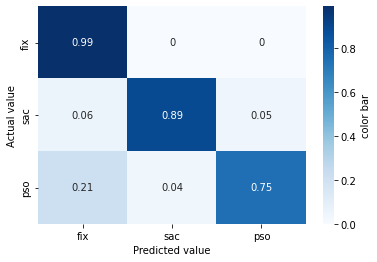

In [ ]:
import seaborn as sns
cm_normalized=np.round(CM/np.sum(CM, axis=1).reshape(-1, 1), 2)
print(cm_normalized)
sns.heatmap(cm_normalized, cmap='Blues', annot=True, cbar_kws={"orientation": "vertical", "label": "color bar"}, xticklabels=['fix','sac','pso'], yticklabels=['fix', 'sac', 'pso'])
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.show()